In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set(style='whitegrid')

In [3]:
df= pd.read_csv('ai_human_detection_v1.csv')
df.head(3)

,id,text,human_or_ai,source_model,prompt,domain,language,edit_level,word_count,generation_date,version
0,e37e31c0-35d0-486d-9760-efadd4e0e289,Aprender programación en Python es fácil . Pri...,human,Human,NaN,Technical Blog,es,none,34,2026-01-29T08:38:18.272755,v1.0
1,68e294cf-a499-4fbf-8616-2d6324570be9,Error: 400 Client Error: Bad Request for url: ...,ai,gemma2-9b-it,Discute el papel de la tecnología en el aprend...,Education,es,none,9,2026-01-29T08:58:20.717225,v1.0
2,b5e06ef0-9758-471f-81dc-182c6117ee81,Error: 404 Client Error: Not Found for url: ht...,ai,gemma2-9b-itllama-3.3-70b-versatile,Create a cold outreach email for business part...,Email,en,none,9,2026-01-29T09:13:20.114765,v1.0


## Data Cleaning

In [4]:
df.shape

(686, 11)

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               686 non-null    str  
 1   text             686 non-null    str  
 2   human_or_ai      686 non-null    str  
 3   source_model     686 non-null    str  
 4   prompt           505 non-null    str  
 5   domain           686 non-null    str  
 6   language         686 non-null    str  
 7   edit_level       686 non-null    str  
 8   word_count       686 non-null    int64
 9   generation_date  686 non-null    str  
 10  version          686 non-null    str  
dtypes: int64(1), str(10)
memory usage: 59.1 KB


In [6]:
df.isnull().sum()

id                   0
text                 0
human_or_ai          0
source_model         0
prompt             181
domain               0
language             0
edit_level           0
word_count           0
generation_date      0
version              0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,686.0,262.300292,203.517607,9.0,57.0,245.0,393.5,1121.0


In [81]:
cat_cols= df.select_dtypes(include='str').columns
for cols in cat_cols:
    df[cols]= df[cols].fillna('Unknown',inplace=True)

In [82]:
df.describe(include='all')

,id,text,human_or_ai,source_model,prompt,domain,language,edit_level,word_count,generation_date,version,category,10,20,2023,aapko,access,action,address,advanced,agency,ai,air,algorithm,api,apne,app,application,applications,aprendizaje,architecture,areas,artificial,aur,avec,based,believe,benefits,best,blockchain,brain,brand,building,business,businesses,campaign,carbon,career,challenges,change,changes,client,climate,cloud,code,com,communities,community,como,company,...,और,कई,कदम,कर,करत,करन,जल,टर,तन,तर,दन,धत,धन,नक,पत,पन,पर,बढ,बन,भव,मत,मदद,मश,महत,यक,यकत,यर,यह,रक,रण,रत,रद,रभ,रम,रय,रस,रह,लक,लर,वन,वप,वर,वरण,वलपम,वस,वह,शन,शल,षण,सक,सकत,सफलत,सम,समय,सर,सस,सहय,हत,हम,हर
count,686,686,686,686,686,686,686,686,686.000000,686,686,686,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,...,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
unique,686,686,2,4,164,6,7,3,NaN,686,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,e37e31c0-35d0-486d-9760-efadd4e0e289,Aprender programación en Python es fácil . Pri...,ai,llama-3.1-8b-instant,Unknown,Social Media,en,none,NaN,2026-01-29T08:38:18.272755,v1.0,ai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,505,499,181,121,246,516,NaN,1,686,505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.300292,NaN,NaN,NaN,0.003847,0.010149,0.002858,0.002243,0.004372,0.003680,0.004082,0.005921,0.004849,0.016660,0.005145,0.003037,0.006206,0.007530,0.004093,0.006709,0.002953,0.003539,0.003115,0.003871,0.004933,0.018551,0.004503,0.004087,0.011930,0.003026,0.010058,0.008073,0.007475,0.004105,0.003363,0.005202,0.003101,0.003213,0.007837,0.006988,0.002764,0.009406,0.002730,0.004758,0.008414,0.008357,0.005199,0.005223,0.003531,0.011253,0.004387,0.021258,...,0.04161

In [22]:
df['human_or_ai'].unique()

<StringArray>
['human', 'ai', 'post_edited_ai']
Length: 3, dtype: str

## Visualization

#### AI vs HUMAN

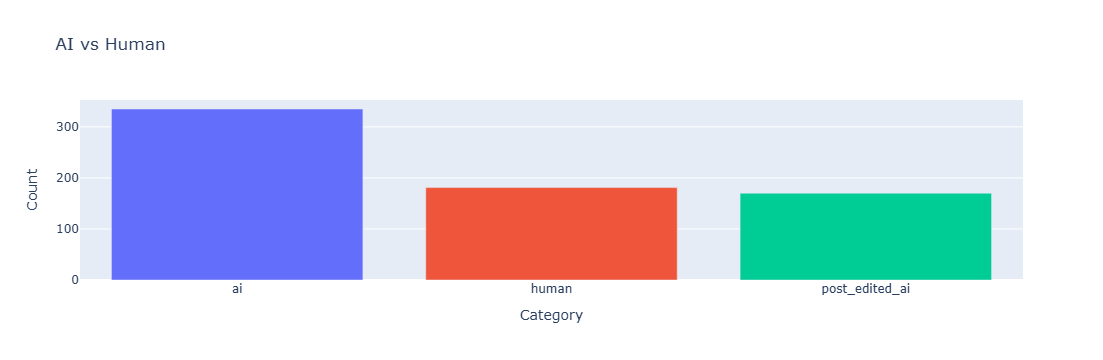

In [44]:
counts= df['human_or_ai'].value_counts().reset_index()
counts.columns=['Category','Counts']

fig= px.bar(counts,x='Category',y='Counts',color='Category',title='AI vs Human')
fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Category', 
                  yaxis_title='Count',
                  showlegend=False)
fig.show()

#### Word count

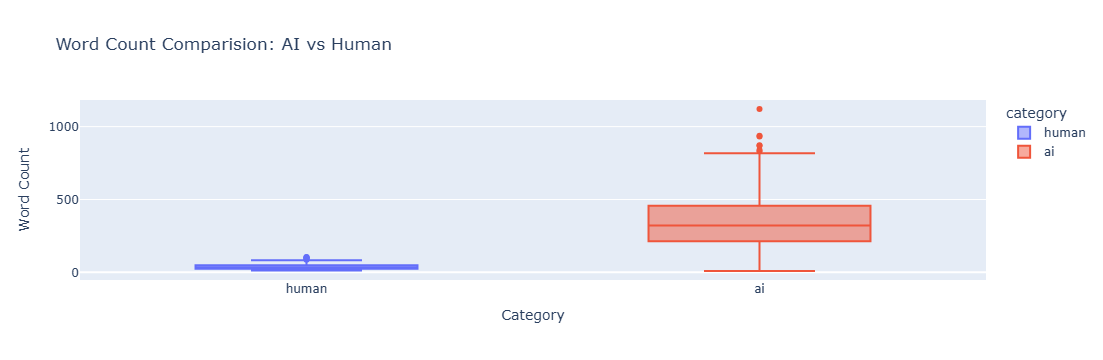

In [55]:
df['category']= df['human_or_ai'].replace({'post_edited_ai':'ai'})
fig= px.box(df,x='category',y='word_count',color='category',title='Word Count Comparision: AI vs Human')
fig.update_layout(xaxis_title='Category',yaxis_title='Word Count')
fig.show()

#### Domain Distribution

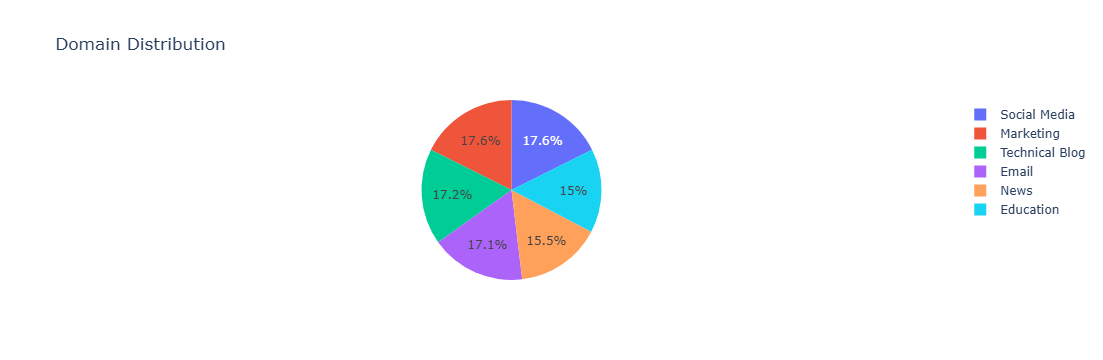

In [59]:
domain_counts= df['domain'].value_counts().reset_index()
domain_counts.columns= ['Domain','Count']

fig = px.pie(domain_counts, 
             values='Count', 
             names='Domain',
             title='Domain Distribution')
fig.show()

#### Language distribution

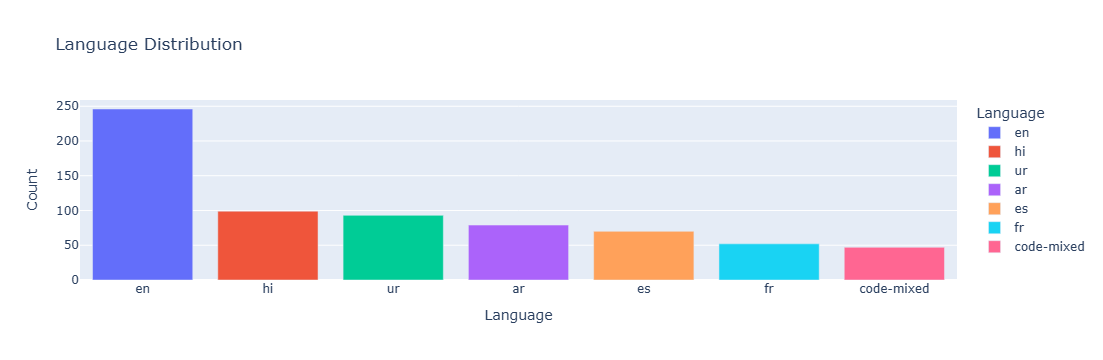

In [65]:
language_count= df['language'].value_counts().reset_index()
language_count.columns=['Language','Count']

fig= px.bar(language_count,x='Language',y='Count',color='Language',title='Language Distribution',color_continuous_scale='Blue')
fig.show()

In [74]:
df['human_or_ai']= df['human_or_ai'].replace('post_edited_ai','ai',inplace=True)

## Vectorization

In [80]:
text_data= df['text']
vect= TfidfVectorizer(max_features=500,stop_words='english')
X_tfidf = vect.fit_transform(text_data)

tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=vect.get_feature_names_out(),
    index=df.index
)

df = pd.concat([df, tfidf_df], axis=1)

df.head()

,id,text,human_or_ai,source_model,prompt,domain,language,edit_level,word_count,generation_date,version,category,10,20,2023,aapko,access,action,address,advanced,agency,ai,air,algorithm,api,apne,app,application,applications,aprendizaje,architecture,areas,artificial,aur,avec,based,believe,benefits,best,blockchain,brain,brand,building,business,businesses,campaign,carbon,career,challenges,change,changes,client,climate,cloud,code,com,communities,community,como,company,...,और,कई,कदम,कर,करत,करन,जल,टर,तन,तर,दन,धत,धन,नक,पत,पन,पर,बढ,बन,भव,मत,मदद,मश,महत,यक,यकत,यर,यह,रक,रण,रत,रद,रभ,रम,रय,रस,रह,लक,लर,वन,वप,वर,वरण,वलपम,वस,वह,शन,शल,षण,सक,सकत,सफलत,सम,समय,सर,सस,सहय,हत,हम,हर
0,e37e31c0-35d0-486d-9760-efadd4e0e289,Aprender programación en Python es fácil . Pri...,human,Human,NaN,Technical Blog,es,none,34,2026-01-29T08:38:18.272755,v1.0,human,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.451313,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,68e294cf-a499-4fbf-8616-2d6324570be9,Error: 400 Client Error: Bad Request for url: ...,ai,gemma2-9b-it,Discute el papel de la tecnología en el aprend...,Education,es,none,9,2026-01-29T08:58:20.717225,v1.0,ai,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.364344,0.000000,0.0,0.0,0.364344,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,b5e06ef0-9758-471f-81dc-182c6117ee81,Error: 404 Client Error: Not Found for url: ht...,ai,gemma2-9b-itllama-3.3-70b-versatile,Create a cold outreach email for business part...,Email,en,none,9,2026-01-29T09:13:20.114765,v1.0,ai,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.387807,0.000000,0.0,0.0,0.387807,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6177fc40-1567-445b-af15-f3250ddd3403,**Global Economic Trends: A Shifting Landscape...,ai,llama-3.1-8b-instant,Write about economic trends affecting global m...,News,en,none,558,2026-01-29T08:39:55.917663,v1.0,ai,0.034127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073528,0.201832,0.0,0.0,0.0,0.0,0.071094,0.086444,0.000000,0.075334,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,192a9615-ed51-4750-b649-d18f8882f555,"""Recuerda que tú eres fuerte, capaz y única. N...",ai,llama-3.1-8b-instant,Escribe una publicación inspiradora para redes...,Social Media,es,none,147,2026-01-29T08:42:52.451370,v1.0,ai,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Logistic Regression Model & Visualization

In [117]:
label= LabelEncoder()
df['label_human_vs_ai']=label.fit_transform(df['human_or_ai'])

#Model
log_reg= LogisticRegression()

X= tfidf_df
y= df['label_human_vs_ai']

X_train,X_test,y_train,y_test= train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)
log_reg.fit(X_train,y_train)
y_pred= log_reg.predict(X_test)

accuracy= accuracy_score(y_test,y_pred)
precision= precision_score(y_test,y_pred)
f1= f1_score(y_test,y_pred)
recall= recall_score(y_test,y_pred)

print(f"Accuracy score: {accuracy * 100:.4f}%")
print(f"Precision score: {precision * 100:.4f}%")
print(f"F1 score: {f1 * 100:.4f}%")
print(f"Recall score: {recall * 100:.4f}%")

Accuracy score: 84.7826%
Precision score: 100.0000%
F1 score: 58.8235%
Recall score: 41.6667%


#### Confusion matrix

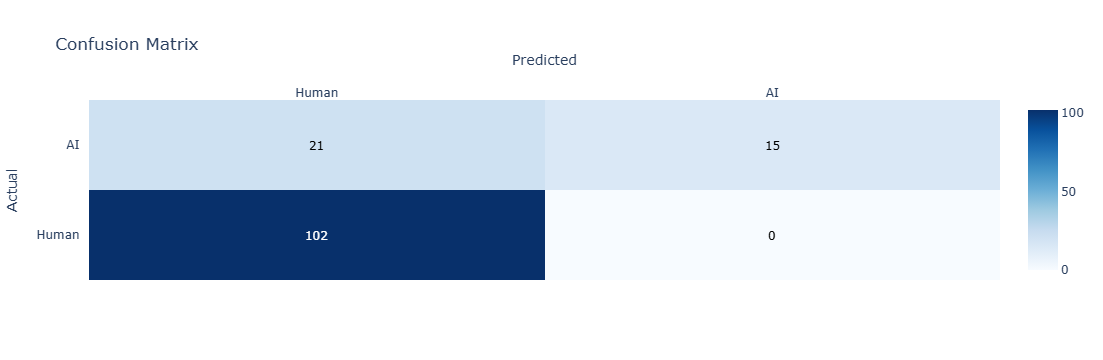

In [109]:
cm = confusion_matrix(y_test, y_pred)

labels = ['Human', 'AI']

fig = ff.create_annotated_heatmap(cm, 
                                   x=labels, 
                                   y=labels,
                                   colorscale='Blues',
                                   showscale=True)

fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted',
                  yaxis_title='Actual')
fig.show()

#### Performance matrix

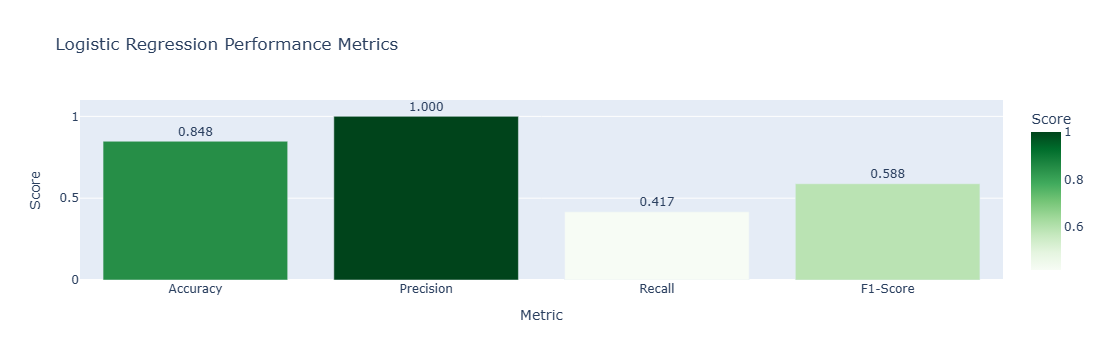

In [118]:
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_data)

fig = px.bar(metrics_df, 
             x='Metric', 
             y='Score',
             title='Logistic Regression Performance Metrics',
             color='Score',
             color_continuous_scale='Greens',
             text='Score')

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis_range=[0, 1.1])
fig.show()

#### Domain wise

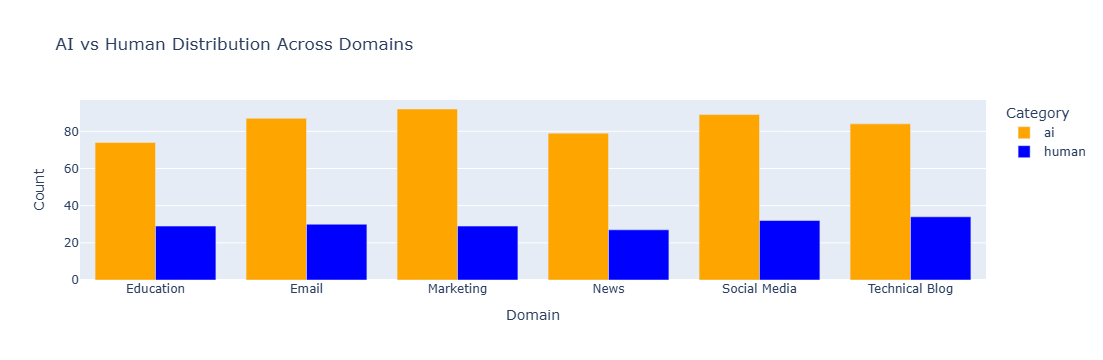

In [124]:
df['category'] = df['human_or_ai'].replace({'post_edited_ai': 'ai'})

domain_category = df.groupby(['domain', 'category']).size().reset_index(name='Count')

fig = px.bar(domain_category, 
             x='domain', 
             y='Count',
             color='category',
             title='AI vs Human Distribution Across Domains',
             barmode='group',
             color_discrete_map={'ai': 'orange', 'human': 'blue'})

fig.update_layout(xaxis_title='Domain', 
                  yaxis_title='Count',
                  legend_title='Category')
fig.show()

#### Word count VS index

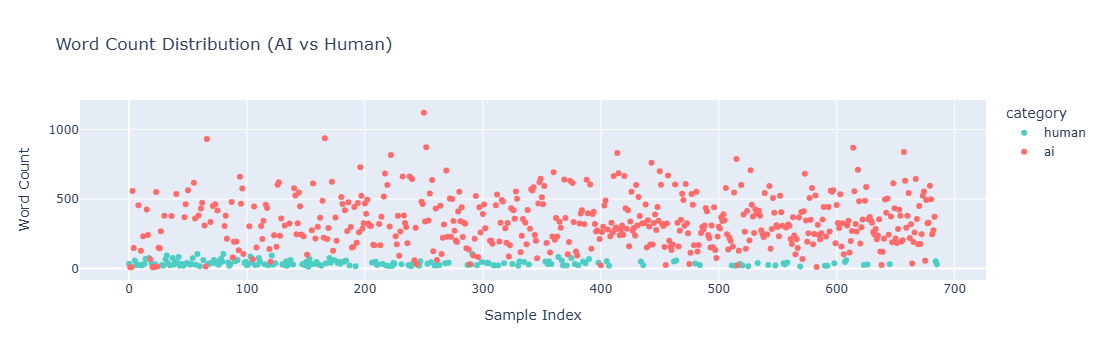

In [127]:
df = df.loc[:, ~df.columns.duplicated()]
df['category'] = df['human_or_ai']

fig = px.scatter(df, 
                 x=df.index, 
                 y='word_count',
                 color='category',
                 title='Word Count Distribution (AI vs Human)',
                 color_discrete_map={'ai': '#FF6B6B', 'human': '#4ECDC4'},
                 hover_data=['domain', 'language'])

fig.update_layout(xaxis_title='Sample Index', 
                  yaxis_title='Word Count')
fig.show()

In [131]:
print("\n" + "="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"Total Samples: {len(df)}")
print(f"AI Samples: {len(df[df['human_or_ai']=='ai'])}")
print(f"Human Samples: {len(df[df['human_or_ai']=='human'])}")
print(f"\nFeatures Used: {X.shape[1]}")
print(f"Feature Name: word_count")
print(f"\nModel: Logistic Regression")
print(f"Train-Test Split: 80-20")
print(f"\nTest Set Performance:")
print(f"  - Accuracy:  {accuracy*100:.2f}%")
print(f"  - Precision: {precision:.3f}")
print(f"  - Recall:    {recall:.3f}")
print(f"  - F1-Score:  {f1:.3f}")
print("="*60)


PROJECT SUMMARY
Total Samples: 686
AI Samples: 505
Human Samples: 181

Features Used: 500
Feature Name: word_count

Model: Logistic Regression
Train-Test Split: 80-20

Test Set Performance:
  - Accuracy:  84.78%
  - Precision: 1.000
  - Recall:    0.417
  - F1-Score:  0.588
